## Исследование надежности заемщиков

### Legend
- children — количество детей в семье
- days_employed — общий трудовой стаж в днях
- dob_years — возраст клиента в годах
- education — уровень образования клиента
- education_id — идентификатор уровня образования
- family_status — семейное положение
- family_status_id — идентификатор семейного положения
- gender — пол клиента
- income_type — тип занятости
- debt — имел ли задолженность по возврату кредитов
- total_income — ежемесячный доход
- purpose — цель получения кредита

In [1]:
import pandas as pds
import seaborn

In [2]:
try:
    data = pds.read_csv('../db.tst/data.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv')

url5 = '/datasets/real_estate_data.csv'

In [3]:
# data information

data.head(2)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


### Data preprocessing

In [1]:
data.isna().sum()

NameError: name 'data' is not defined

In [6]:
total_income_median = data.groupby('income_type')['total_income'].median()

def fill_total_income_na1():
    for i in range(len(total_income_median.keys())):
        con1 = data['income_type']==total_income_median.keys()[i]
        value = total_income_median[i]
        data.loc[con1, 'total_income'] = data['total_income'].fillna(value)

def fill_total_income_na2():
    for t in data['income_type'].unique():
        data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
        data.loc[(data['income_type'] == t), 'total_income'].median()

In [7]:
days_employed_medians = data.groupby('income_type')['days_employed'].median()
len_by_type = len(days_employed_medians)

for i in range(len_by_type):
    con1 = data['income_type']==days_employed_medians.keys()[i]
    value = days_employed_medians[i]
    data.loc[con1, 'days_employed'] = data['days_employed'].fillna(value)

In [8]:
data['days_employed'] = data['days_employed'].abs()

In [9]:
con_neg_child = data['children']<0
con_child_20 = data['children']>=20
row_index = data.loc[con_neg_child | con_child_20, 'children']
#print(row_index.keys())
#print(data[con_neg_child | con_child_20].index)

data = data.drop(row_index.keys())

def rewrite_data():
    data = data[(data['children'] != -1) & (data['children'] != 20)]

In [10]:
data.groupby('income_type')['days_employed'].median().head(2)
#data.groupby('income_type')['days_employed'].agg('median')
data['children'].unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

In [11]:
# converting data type
data['total_income'] = data['total_income'].astype('int')

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
#duplicates

data['education'] = data['education'].str.lower()
data['education'].value_counts()

среднее                15136
высшее                  5237
неоконченное высшее      741
начальное                282
ученая степень             6
Name: education, dtype: int64

In [ ]:
data.duplicated().sum()

0

In [ ]:
# duplicate resolving
data = data.drop_duplicates().reset_index(drop=True) 

In [ ]:
#categorization

def categorize_income(row):
    total_income = row['total_income']
    
    try:
        if 0 <= total_income <= 30000:
            return 'E'
        elif 30001 <= total_income <= 50000:
            return 'D'
        elif 50001 <= total_income <= 200000:
            return 'C'
        elif 200001 <= total_income <= 1000000:
            return 'B'
        elif total_income >= 1000001:
            return 'A'
    except:
        return f'Bad data in row {total_income}'

data['total_income_category'] = data.apply(categorize_income, axis=1)

In [ ]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

data['purpose_category'] = data['purpose'].apply(categorize_purpose)

## Часть 2: Исследование данных

### Задача 19: Зависимость между количеством детей и возвратом кредита в срок

In [16]:
# Сгруппируем данные по зависимости количества детей и данные по задолженности кредитов
# 1 - есть задолженность
# 0 - нет задолженности
data.groupby(['children', 'debt'])['debt'].count()


children  debt
0         0       13086
          1        1063
1         0        4374
          1         444
2         0        1861
          1         194
3         0         303
          1          27
4         0          37
          1           4
5         0           9
Name: debt, dtype: int64

In [15]:
data.groupby(['children', 'debt'])['debt'].count().describe().T

count       11.000000
mean      1945.636364
std       3919.908526
min          4.000000
25%         32.000000
50%        303.000000
75%       1462.000000
max      13086.000000
Name: debt, dtype: float64

<AxesSubplot:xlabel='children,debt'>

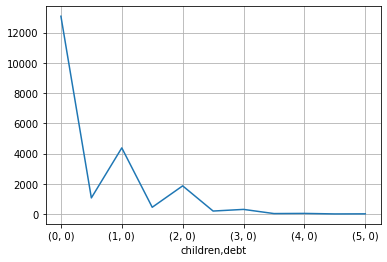

In [18]:
data.groupby(['children', 'debt'])['debt'].count().plot(grid=True)

<AxesSubplot:>

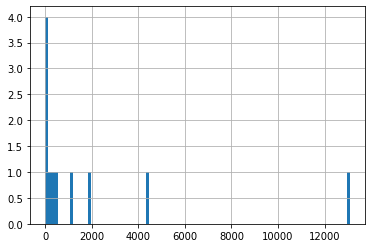

In [19]:
data.groupby(['children', 'debt'])['debt'].count().hist( bins=100)

In [ ]:
# data.groupby('children')['debt'].value_counts()[0][0]
# data.groupby('children')['debt'].value_counts()[0][1]
#debt_by_children_s = data.groupby('children')['debt'].value_counts()
children_grouped = data.groupby(['children', 'debt']).agg({'debt':['count']})
children_grouped


debt
               count
children debt       
0        0     13086
         1      1063
1        0      4374
         1       444
2        0      1861
         1       194
3        0       303
         1        27
4        0        37
         1         4
5        0         9

In [ ]:
pivot_children = data.pivot_table(index=['children'], columns='debt', aggfunc='count', fill_value=0)
pivot_children

pivot_children['conversion_0'] = pivot_children['days_employed'][0]/(pivot_children['days_employed'][0] + pivot_children['days_employed'][1])*100
pivot_children['conversion_1'] = pivot_children['days_employed'][1]/(pivot_children['days_employed'][0] + pivot_children['days_employed'][1])*100
pivot_children[['days_employed', 'conversion_0', 'conversion_1']]



days_employed       conversion_0 conversion_1
debt                 0     1                          
children                                              
0                13086  1063    92.487102     7.512898
1                 4374   444    90.784558     9.215442
2                 1861   194    90.559611     9.440389
3                  303    27    91.818182     8.181818
4                   37     4    90.243902     9.756098
5                    9     0   100.000000     0.000000

In [ ]:

pivot_children1 = data.pivot_table(index=['children'], values = 'education_id',columns=['debt'], aggfunc='count', fill_value=0)


pivot_children1['people_with_no_debt'] = (pivot_children1[0]/(pivot_children1[0]+pivot_children1[1])*100).round()
pivot_children1['people_with_debt'] = (pivot_children1[1]/(pivot_children1[0]+pivot_children1[1])*100).round()
tmp = pivot_children1

tmp['conversion'] = tmp[1]/tmp[0] * 100
tmp
tmp[[0, 'people_with_no_debt']]


debt,0,people_with_no_debt
children,,
0,13086,92.0
1,4374,91.0
2,1861,91.0
3,303,92.0
4,37,90.0
5,9,100.0


#### Вывод:

### Задача 20: Зависимость между семейным положением и возвратом кредита в срок

In [ ]:
# family_status_id — идентификатор семейного положения = [0, 1, 2, 3, 4]
# family_status — семейное положение ['женат / замужем', 'гражданский брак', 'вдовец / вдова', 'в разводе', 'Не женат / не замужем']

data['family_status'].unique()
data.groupby(['family_status', 'debt'])['debt'].count()

family_status          debt
Не женат / не замужем  0        2526
                       1         273
в разводе              0        1105
                       1          84
вдовец / вдова         0         889
                       1          63
гражданский брак       0        3775
                       1         385
женат / замужем        0       11375
                       1         927
Name: debt, dtype: int64

In [ ]:
pivot_family = data.pivot_table(index=['family_status'], values = 'education_id',columns=['debt'], aggfunc='count', fill_value=0)
pivot_family

pivot_family['people_with_no_debt'] = (pivot_family[0]/(pivot_family[0]+pivot_family[1])*100).round()
pivot_family['people_with_debt'] = (pivot_family[1]/(pivot_family[0]+pivot_family[1])*100).round()
pivot_family[[0, 'people_with_no_debt']]

debt,0,people_with_no_debt
family_status,,
Не женат / не замужем,2526,90.0
в разводе,1105,93.0
вдовец / вдова,889,93.0
гражданский брак,3775,91.0
женат / замужем,11375,92.0


### Задача 21: Зависимость между уровнем дохода и возвратом кредита в срок

In [ ]:
# total_income — ежемесячный доход
# total_income_category, детали в задаче 

data.groupby(['total_income_category', 'debt'])['debt'].count()

pivot_income = data.pivot_table(index=['total_income_category'], values = 'education_id',columns=['debt'], aggfunc='count', fill_value=0)

pivot_income['people_with_no_debt'] = (pivot_income[0]/(pivot_income[0]+pivot_income[1])*100).round()
pivot_income['people_with_debt'] = pivot_income[1]/(pivot_income[0]+pivot_income[1])*100
pivot_income[[0, 'people_with_no_debt']]

debt,0,people_with_no_debt
total_income_category,,
A,23,92.0
B,4659,93.0
C,12648,91.0
D,328,94.0
E,20,91.0


### Задача 22: Влияние целей кредита на возврат в срок

In [ ]:
# purpose — цель получения кредита
# purpose_category

data.groupby(['purpose_category', 'debt'])['debt'].count()

pivot_purpose = data.pivot_table(index=['purpose_category'], values = 'education_id',columns=['debt'], aggfunc='count', fill_value=0)

pivot_purpose['people_with_no_debt'] = (pivot_purpose[0]/(pivot_purpose[0]+pivot_purpose[1])*100).round()
pivot_purpose['people_with_debt'] = pivot_purpose[1]/(pivot_purpose[0]+pivot_purpose[1])*100
pivot_purpose[[0, 'people_with_no_debt']]

debt,0,people_with_no_debt
purpose_category,,
операции с автомобилем,3888,91.0
операции с недвижимостью,10000,93.0
получение образования,3628,91.0
проведение свадьбы,2154,92.0


### Задача 23: Возможные причины появления пропусков в исходных данных

### Задача 24: Почему заполнить пропуски медианным значением — лучшее решение для количественных переменных

### Общий вывод.

<p>Данное иследование покажет зависимость по закрытию задолженности человека с разными статусами: по детям, по семье, по зароботку, по целям.
Выводы могут быть использованы для построения модели, которая сможет оценить возврат кредита в срок.
</p>

**Рассмотрим каждую гипотизу отдельно:**

**Гипотеза №1**: Зависимость погашения задолженности по количеству детей. (частично подтверждена)
<p>К сожалению, данные для анализа не равномерны, поэтому нужны будут дополнительные показатели по группе "с 4 детьми" и "с 5ю детьми"</p>
<p>Результат анализа:</p>
1) Сделаем выводы основываясь по показателям успешно закрытого кредита
<pre>
debt	0	people_with_no_debt
children		
0	13086	92.0
1	4374	91.0
2	1861	91.0
3	303	    92.0
4	37	    90.0
5	9	    100.0
</pre>
Отдельно рассмотрим группу с 5ю детьми: 
- очень редкая группа, но это логично, по все стране не там много многодетных семей по сравнению с бездетными или семьи с 1 или 2 детьми
- но она показала хороший результат, 9 из 9 погасили задолженность, на данном этапе они явно войдут в рекомендацию
- возможно у них есть какие-то льготы и они попадают под социальные программы, поэтому им легче закрыть кредит.
<p>Теперь рассмотрим остальные группы:</p>
- многочисленная группа по стране это бездетные, они по сравнению с семьями с одним или 2 ребенками закрывают задолженность намного лучше. Это может говорить о том, что им легче накопить нужную сумму, так как им не нужно тратить деньги на детей, а затраты на детей очень высокие. 
- 3 и 4 группы уже не такие многочисленные, семей с 3 и 4 детьми тоже не так много, но результат очень интересный: дети с 3 детьми закрывают кредит намного лучше. Могу предположить что 3 детей уже может позволить не каждая семья и это должны быть обеспеченные люди. А с 4 детьми уже даже для богатых семей идет большая нагрузка на бюджет семьи.

Исходя из этого я считаю, что зависимость есть, она не сильная и по некоторым группам требуются дополнительные статистические данные, 3 группы всетаки показывают хорошую надежность по сравнению с другими: бездетные, с 3мя детьми и с 5 детьми

**Гипотеза №2**: Зависимость погашения задолженности по семейному статусу. (гипотиза потвердилась, большой разницы нет)
<p>Результат анализа:</p>
1) Сделаем выводы основываясь по показателям успешно закрытого кредита
<pre>
debt	0	people_with_no_debt
family_status		
Не женат / не замужем	2526	90.0
в разводе	            1105	93.0
вдовец / вдова	        889	    93.0
гражданский брак	    3775	91.0
женат / замужем	        11375	92.0
</pre>

<p>Судя по статистике у нас больше семейных людей берут кредит, меньше всего берут кредит люди одинокие. Можно сделать вывод, что семейные люди чувствуют поддержку во второй половине или расчитывают на семейный буджет, все-таки больше вероятность что зарабатывают оба партнера и шанс погасить кредит больше.</p>
<pre>
Одинокие люди могут расчитывать только на себя поэтому и к кредиту подходят только в крайних случаях.

А теперь по конверсии:
Хорошие показатели у людей которые были в браке, но у них не сложилась семейная жизнь либо были трагические обстоятельства. Могу сделать вывод, что такие люди не хотят себя обременять дополнительными проблемами и стараются закрывать кредит вовремя.

Люди в отношениях стоят по середине, у них не такие высокие показатили, но они показывают большинство и стандарт, причем те кто подолшли к браку официально и серьезно показали свои намерения, закрывают кредит лучше чем те кто не заключил официальный брак.

Хуже всего обстоят дела у людей которые не готовы к отношениям. Можно предположить, что это не совсем состоявшиеся люди и у них есть перебои с заработком или проблемы с финансами и поэтому они еще не готовы делать шаг к семье, соответственно если есть проблемы с финансами, то и риски больше по невозврату кредита вовремя.
</pre>

**Гипотеза №3**: Зависимость погашения задолженности по доходам. (гипотиза частично потвердилась, есть малочисленные группы)
<p>Результат анализа:</p>
1) Сделаем выводы основываясь по показателям успешно закрытого кредита
<pre>
debt	0	people_with_no_debt
total_income_category		
A	23	    92.0
B	4659	93.0
C	12648	91.0
D	328	    94.0
E	20	    91.0
</pre>

<pre>
Расшифровка групп по доходу:
    0–30000 — 'E';
    30001–50000 — 'D';
    50001–200000 — 'C';
    200001–1000000 — 'B';
    1000001 и выше — 'A'
</pre>

<pre>
    Посмотрим статистику по количеству людей:
    Малочисленна группа с доходом от миллиона рублей (A), но это не удивительно. Таких людей по сравнению со средним и низким доходам и в жизни мало. 
    Плюс таким людям скорее всего кредит будет нужен для бизнеса. Но сразу замечу, что они не лидеры по закрытию кредита. они больше середнячекк по погашению, скорее всего риски у них тоже высокие по прибыльности.

    Две вторые мамлочисленные группы это люди с низким доходом или вообще без дохода (E и D), что маловероятно, но группа начинается от 0 р.
    Сразу замечу что група с самым низким догодом (E) меньше берет кредит и хуже его возвращает - 91% только вовремя погасили кредит. Для таких людей есть риски с тем куда потратить деньги и на что.

    Вторая группа, которая плохо погасила кредит (91% погасили вовремя) и входит в группу рисков - это люди с доходом 50001–200000 (C). Она саммая большая и скорее всего нужны дополнительные анализы по этой группе, по другим параметрам, чтобы ее лучше понять. Так как эта группа не выглядит теми кто может нуждаться в деньгах и есть множество разных дополнительных факторов, которые будут влиять на риски не вернуть кредит, либо они как раз переоценивают себя и не могут ясно оценить риски погашения.

    Самые надежные группы это D (30001–50000) и B (200001–1000000). D это группа с невысоким доходом, 
    что скорее всего влияет на оценку рисков. Так как не уплата для них - лишняя нагрузка на бюджет. 
    Плюс они относятся к людям которых по статистике тоже много и это самые распространенные профессии.
    Это образованные люди которые должны хорошо следит за своим бюджетом, поэтому к кредиту относятся ответственно, 
    лишнего не берут и возвращают вовремя. Будут входить в надежную группу, 94% возврата .

    Группа B тоже надежная, но не настолько, 93%. На 1% меньше группы D, хотя доход у них больше, но и цели по кредитам значит тоже выше.
    Поэтому и риск с большими суммами больше. По сравнению с другими группами они тоже могут войти в надежную группу по кредитам.
</pre>


**Гипотеза №4**: Зависимость погашения задолженности по целям кредита. (гипотиза подтвердилась)
<p>Результат анализа:</p>
1) Сделаем выводы основываясь по показателям успешно закрытого кредита
<pre>
debt	0	people_with_no_debt
purpose_category		
операции с автомобилем	    3888	91.0
операции с недвижимостью	10000	93.0
получение образования	    3628	91.0
проведение свадьбы	        2154	92.0
</pre>

<pre>
    Исходя из статистики больше всего кредит берут на операции с недвижимостью (10 000 успешно покасили кредит).
    Такие цели относятся к очень большой сумме и могут браться для личных нужд или для бизнеса. И обычно такие суммы 
    идут на долгосрочный срок. Соответственно люди к этому подходят более ответственно и расчитывают свой план погашения на долгое 
    время вперед. По погашению без задолженности это самая надежная группа (93% погалили вовремя)

    Вторая по надежности это группа целей на свадьбу (93%). На нее по статистике берут кредит меньше всего, но погашают также успешно как и 
    по операциям с недвижимостью, разница в 1%. Но и суммы на свадьбу соответственно меньше чем на жилье.

    Две смые рискованные группы (91% погашения) это автомобиль (что можно отнести к роскоши и престижу, 
    если хорошо развит общественный транспорт). И образование, по которому мне тяжело сдлать какието выводи.
    Почему образование попало в группу рисков, нужно будет делать дополнительный анализ, но статистика для 
    вывода хорошая и факт есть факт. Также и по автомобилям, сумма по сравнению с образованием от милиона и выше.
    Поэтому не удивительно, что его погасить тяжело, а автомобиль хотят все, даже те кто только предполагает что 
    может себе его позволить, Плюс автомобиль требует дополнительных затрат о которых сразу не все подозревают.
</pre>


**Общие рекомендации**

<pre>
В гипотизах достаточно статических данных чтобы можно было по ним прогнозировать и доверять им.

В гипотезах 1 и 3 есть малочисленные группы, по которым нужно копить статистику и возможно результат уже будет другим на больших данных. 
Поэтому рано делать прогнозы и добавлять в надежную группу.
</pre>

<AxesSubplot:xlabel='0', ylabel='people_with_no_debt'>

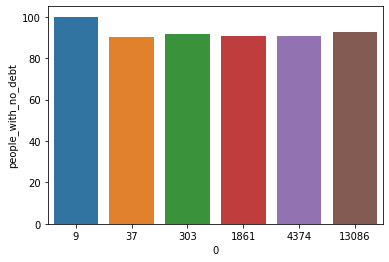

In [ ]:
seaborn.barplot(x=pivot_children1[0], y=pivot_children1['people_with_no_debt'])

In [ ]:
our_series = pds.Series([10,11,12,3])
df = pds.DataFrame({
    'a': [0, 1, 10, 1, 12],
    'b': [5, 4, 3, 2, 1],
    'c': ['X', 'Y', 'Y', 'Y', 'Z']
})

df.query('a in @our_series.index')
#df
#our_series.index

,a,b,c
0,0,5,X
1,1,4,Y
3,1,2,Y
